<a href="https://colab.research.google.com/github/shachki/Datamining---abstract-classification/blob/main/Copy_of_data_mining_finetuninng.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import os
import sys
# from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoModel, AutoConfig
import wandb
import numpy as np
import pandas as pd

def map_category(arxiv_cat):

    # Physics subfields
    if arxiv_cat.startswith("cond-mat"):
        return "Condensed Matter Physics"
    elif arxiv_cat in {"hep-th", "hep-ph", "hep-ex", "hep-lat"}:
        return "High Energy Physics"
    elif arxiv_cat.startswith("astro-ph"):
        return "Astrophysics"
    elif arxiv_cat in {"nucl-th", "nucl-ex"}:
        return "Nuclear Physics"
    elif arxiv_cat == "quant-ph":
        return "Quantum Physics"
    elif arxiv_cat == "gr-qc":
        return "Relativity and Cosmology"
    elif arxiv_cat in {"physics.atom-ph", "physics.optics", "physics.plasm-ph", "physics.atm-clus"}:
        return "AMO / Optics"
    elif arxiv_cat.startswith("physics.") or arxiv_cat in {
        "physics.gen-ph", "physics.pop-ph", "physics.bio-ph", "physics.chem-ph", "physics.data-an",
        "physics.comp-ph", "physics.class-ph", "physics.geo-ph", "physics.acc-ph",
        "physics.hist-ph", "physics.flu-dyn", "physics.med-ph", "physics.ed-ph",
        "physics.ins-det", "physics.ao-ph", "physics.space-ph", "physics.app-ph"
    }:
        return "Other Physics"

    # Mathematics subfields
    elif arxiv_cat in {"math.RA", "math.RT", "math.AC", "math.KT", "math.GR", "math.OA", "math.LO", "math.CT"}:
        return "Algebra / Logic"
    elif arxiv_cat in {"math.AG", "math.GT", "math.DG", "math.SG", "math.MG", "math.GM", "math.GN"}:
        return "Geometry / Topology"
    elif arxiv_cat in {"math.FA", "math.CV", "math.CA", "math.AP", "math.HO", "math.OC"}:
        return "Analysis / Applied Math"
    elif arxiv_cat in {"math.NT"}:
        return "Number Theory"
    elif arxiv_cat in {"math.CO", "math.DS", "math.PR", "math.SP", "math.ST"}:
        return "Discrete Math / Probability"
    elif arxiv_cat.startswith("math."):
        return "Other Mathematics"

    # Computer Science
    elif arxiv_cat in {"cs.LG", "cs.NE", "stat.ML"}:
        return "Machine Learning"
    elif arxiv_cat in {"cs.AI", "cs.CL", "cs.CV", "cs.NA", "cs.DL"}:
        return "Artificial Intelligence"
    elif arxiv_cat in {"cs.CR", "cs.PF", "cs.LO", "cs.FL"}:
        return "Security / Formal Methods"
    elif arxiv_cat in {"cs.DS", "cs.CC", "cs.ET", "cs.PL", "cs.OH", "cs.CG"}:
        return "Theory / Algorithms"
    elif arxiv_cat in {"cs.DB", "cs.SE", "cs.DC", "cs.NI", "cs.OS"}:
        return "Systems / Software"
    elif arxiv_cat in {"cs.HC", "cs.MS", "cs.IR", "cs.RO", "cs.SY", "cs.SI", "cs.CY", "cs.CE", "cs.MM", "cs.MA", "cs.SC", "cs.GR", "cs.GT", "cs.AR", "cs.PF"}:
        return "Other Computer Science"

    # Quantitative Biology
    elif arxiv_cat in {"q-bio.NC"}:
        return "Neuroscience"
    elif arxiv_cat in {"q-bio.CB"}:
        return "Cell Biology"
    elif arxiv_cat in {"q-bio.PE"}:
        return "Population Biology"
    elif arxiv_cat in {"q-bio.GN", "q-bio.MN"}:
        return "Genomics"
    elif arxiv_cat in {"q-bio.QM", "q-bio.OT", "q-bio.BM", "q-bio.SC", "q-bio.TO"}:
        return "Biological Modeling"

    # Quantitative Finance
    elif arxiv_cat.startswith("q-fin."):
        return "Quantitative Finance"

    # Statistics
    elif arxiv_cat.startswith("stat."):
        return "Statistics"

    # Electrical Engineering and Systems Science
    elif arxiv_cat.startswith("eess."):
        return "Electrical Engineering / Signal Processing"

    # Economics
    elif arxiv_cat.startswith("econ."):
        return "Economics"

    # Nonlinear Sciences
    elif arxiv_cat.startswith("nlin."):
        return "Nonlinear Science"

    # Fallback
    else:
        return None


In [ ]:
config = AutoConfig.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
%%writefile ex1.py
import argparse
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import wandb
import torch
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def parse_args():
    parser = argparse.ArgumentParser(description="Fine-tune BERT for paper category classification")
    parser.add_argument("--max_train_samples", type=int, default=-1, help="Number of training samples or -1 for all")
    parser.add_argument("--max_eval_samples", type=int, default=-1, help="Number of validation samples or -1 for all")
    parser.add_argument("--max_predict_samples", type=int, default=-1, help="Number of test samples or -1 for all")
    parser.add_argument("--num_train_epochs", type=int, default=3, help="Number of training epochs")
    parser.add_argument("--lr", type=float, default=2e-5, help="Learning rate")
    parser.add_argument("--batch_size", type=int, default=16, help="Batch size for training and evaluation")
    parser.add_argument("--do_train", action="store_true", help="Run training")
    parser.add_argument("--do_predict", action="store_true", help="Run prediction")
    parser.add_argument("--model_path", type=str, default="./results", help="Path to save/load model")
    return parser.parse_args()

def load_and_prepare_data(args, df):
    # Clean and preprocess DataFrame
    df = df.dropna(subset=['abstract', 'categories'])
    df['categories'] = df['categories'].str.strip()
    logger.info(f"Loaded dataset with {len(df)} samples after removing NaNs")
    logger.info(f"Categories distribution:\n{df['categories'].value_counts().to_string()}")


    # Encode categories
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['categories'])
    num_labels = len(label_encoder.classes_)
    logger.info(f"Number of labels: {num_labels}")
    logger.info(f"Label mapping: {dict(zip(label_encoder.classes_, range(num_labels)))}")

    # Split data into train (80%), validation (10%), test (10%)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    eval_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

    logger.info(f"Train size: {len(train_df)}, Eval size: {len(eval_df)}, Test size: {len(test_df)}")

    # Reset indices
    train_df = train_df.reset_index(drop=True)
    eval_df = eval_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # Convert to Hugging Face Datasets
    train_dataset = Dataset.from_pandas(train_df[['abstract', 'label']])
    eval_dataset = Dataset.from_pandas(eval_df[['abstract', 'label']])
    test_dataset = Dataset.from_pandas(test_df[['abstract', 'label']])

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            [str(abstract) for abstract in examples["abstract"]],
            padding="max_length",
            truncation=True,
            max_length=512
        )

    # Tokenize datasets
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    eval_dataset = eval_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Subset data based on args
    if args.max_train_samples != -1:
        train_dataset = train_dataset.select(range(min(args.max_train_samples, len(train_dataset))))
    if args.max_eval_samples != -1:
        eval_dataset = eval_dataset.select(range(min(args.max_eval_samples, len(eval_dataset))))
    if args.max_predict_samples != -1:
        test_dataset = test_dataset.select(range(min(args.max_predict_samples, len(test_dataset))))

    # Set format for PyTorch
    train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    eval_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    return train_dataset, eval_dataset, test_dataset, tokenizer, label_encoder, num_labels

# def compute_metrics(eval_pred):
#     predictions, labels = eval_pred
#     predictions = np.argmax(predictions, axis=1)
#     accuracy = accuracy_score(labels, predictions)
#     precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
#     return {
#         "accuracy": float(accuracy),  # Convert to float for JSON serialization
#         "precision": float(precision),  # Convert to float
#         "recall": float(recall),  # Convert to float
#         "f1": float(f1)  # Convert to float
#     }
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions)
    return {
        "accuracy": float(accuracy),
        "precision": precision.tolist(),  # Convert ndarray to list
        "recall": recall.tolist(),  # Convert ndarray to list
        "f1": f1.tolist()  # Convert ndarray to list
    }
def train_model(args, train_dataset, eval_dataset, num_labels):
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

    # Define training arguments
    training_args = TrainingArguments(
        output_dir=args.model_path,
        eval_strategy="epoch",  # Changed from evaluation_strategy
        save_strategy="epoch",
        learning_rate=args.lr,
        per_device_train_batch_size=args.batch_size,
        per_device_eval_batch_size=args.batch_size,
        num_train_epochs=args.num_train_epochs,
        weight_decay=0.01,
        logging_steps=30,
        save_total_limit=2,
        report_to="wandb",
        run_name=f"lr_{args.lr}_bs_{args.batch_size}_epochs_{args.num_train_epochs}"
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Evaluate and save results
    eval_results = trainer.evaluate()
    logger.info(f"Evaluation results: {eval_results}")
    with open("res.txt", "a") as f:
        f.write(f"lr_{args.lr}_bs_{args.batch_size}_epochs_{args.num_train_epochs}: {eval_results}\n")

    # Save model
    trainer.save_model(args.model_path)
    return trainer

def predict(trainer, test_dataset, label_encoder):
    # Make predictions
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)

    # Convert numerical predictions to category names
    pred_categories = label_encoder.inverse_transform(preds)

    # Save predictions
    with open("predictions.txt", "w") as f:
        for pred in pred_categories:
            f.write(f"{pred}\n")

def main(df):
    args = parse_args()

    # Initialize Weights & Biases (optional)
    try:
        wandb.login()
    except Exception as e:
        logger.warning(f"Failed to login to W&B: {e}. Continuing without W&B logging.")
        args.report_to = None

    # Load and prepare data
    train_dataset, eval_dataset, test_dataset, tokenizer, label_encoder, num_labels = load_and_prepare_data(args, df)

    if args.do_train:
        trainer = train_model(args, train_dataset, eval_dataset, num_labels)

    if args.do_predict:
        if not args.do_train:
            model = AutoModelForSequenceClassification.from_pretrained(args.model_path, num_labels=num_labels)
            training_args = TrainingArguments(
                output_dir=args.model_path,
                per_device_eval_batch_size=args.batch_size,
            )
            trainer = Trainer(
                model=model,
                args=training_args,
                compute_metrics=compute_metrics
            )
        predict(trainer, test_dataset, label_encoder)

if __name__ == "__main__":
    try:
        # Load DataFrame with error handling
        df = pd.read_csv('one_category.csv')
        logger.info(f"Raw CSV loaded with {len(df)} rows")
        # data = df[df['categories'].isin({'hep-ph', 'math.NT', 'cond-mat.soft', 'cs.DS', 'q-bio.OT', 'nucl-th'})]
        # data = data[['abstract', 'categories']]
        # if data.empty:
        #     raise ValueError("Filtered dataset is empty. Check category filtering or input data.")
        logger.info(f"Filtered dataset with {len(df)} rows")
        main(df)
    except Exception as e:
        logger.error(f"Error in main: {e}")
        raise

Writing ex1.py


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/one_category_new.csv')


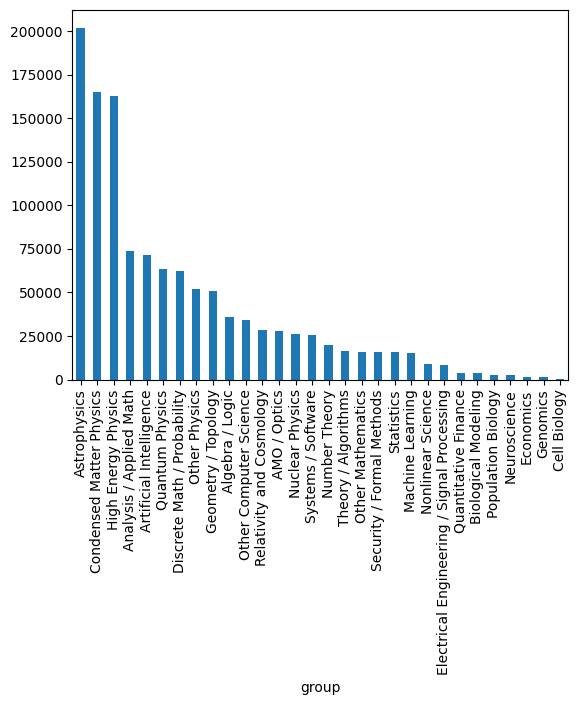

In [ ]:
# plot histogram of df[group]
import matplotlib.pyplot as plt
df['group'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
df_sampled = df.groupby('group', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 4000), random_state=42))


/tmp/ipython-input-8-24898619.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('group', group_keys=False).apply(lambda x: x.sample(n=min(len(x), 4000), random_state=42))


In [ ]:
# Filter out categories that start with "Other"
df_filtered = df_sampled[~df_sampled['group'].str.startswith('Other')]

len(df_filtered['group'].unique())

28

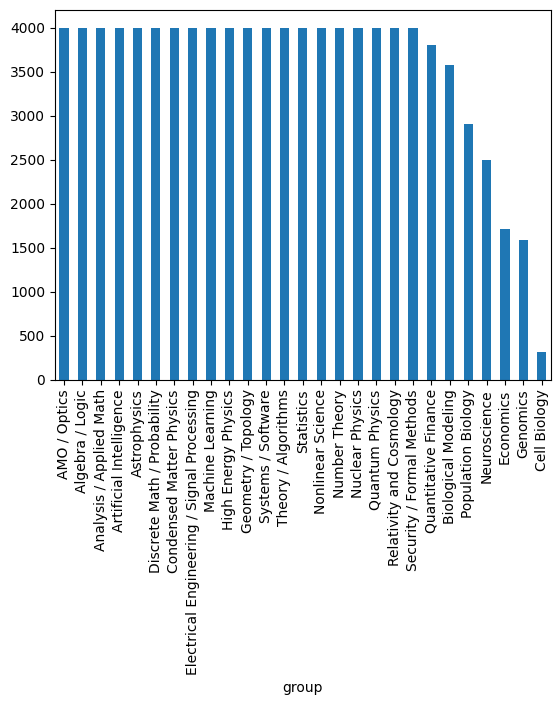

In [ ]:
df_filtered['group'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
# rename df_filtered[group] as categories
df_filtered = df_filtered[['abstract','group']]
df_filtered = df_filtered.rename(columns={'group': 'categories'})


In [ ]:
#save df_sampled as csv file

df_filtered.to_csv('one_category.csv', index=False)


In [ ]:
!python ex1.py --max_train_samples -1 --max_eval_samples -1 --num_train_epochs 2 --lr 2e-5 --batch_size 32 --do_train

2025-06-23 07:01:28.399903: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750662088.420871    3386 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750662088.427219    3386 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: 2
wandb: You chose 'Use an existing W&B account'
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press c

# Infrence and Evaluation

In [ ]:
# save one_category_new.csv to drive
!cp one_category.csv /content/drive/MyDrive/one_category_even.csv

cp: cannot stat 'one_category.csv': No such file or directory


In [ ]:
!cp -r ./results /content/drive/MyDrive/bert_model_results_full

cp: cannot stat './results': No such file or directory


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model_results_full').to('cuda')


In [ ]:
df_filtered.head()

,abstract,categories
0,A fully differential calculation in perturba...,High Energy Physics
2,We show that a determinant of Stirling cycle...,Discrete Math / Probability
3,We study the two-particle wave function of p...,Condensed Matter Physics
4,A rather non-standard quantum representation...,Relativity and Cosmology
5,A general formulation was developed to repre...,Condensed Matter Physics


 first abstract: A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
that enhanced sensitivity to the signal can be obtained with judicious
selection of events.

In [ ]:

txt = tokenizer(df_filtered['abstract'][0], padding=True, truncation=True, max_length=256, return_tensors="pt").to('cuda')# tokenizing the abstract
outputs = model(**txt) # feeding abstract to model
logits= outputs.logits # obtaining logits
predicted_label = torch.argmax(logits, dim=1).cpu().numpy()[0] # picking category with highest probability
predicted_category = label_encoder.inverse_transform([predicted_label])[0] # converting label to category name
predicted_category

'High Energy Physics'

#Full confusion matrix

confusion matrix over the entire dataset, training set has only 4000 samples max for each category while the ull dataset is of the order of magnitude of milion. In the final report we presented the confusion matrix over test set - after splitting the training set into train -test.


Map:   0%|          | 0/111140 [00:00<?, ? examples/s]

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shachar-ashkenazi (cp_ofri) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


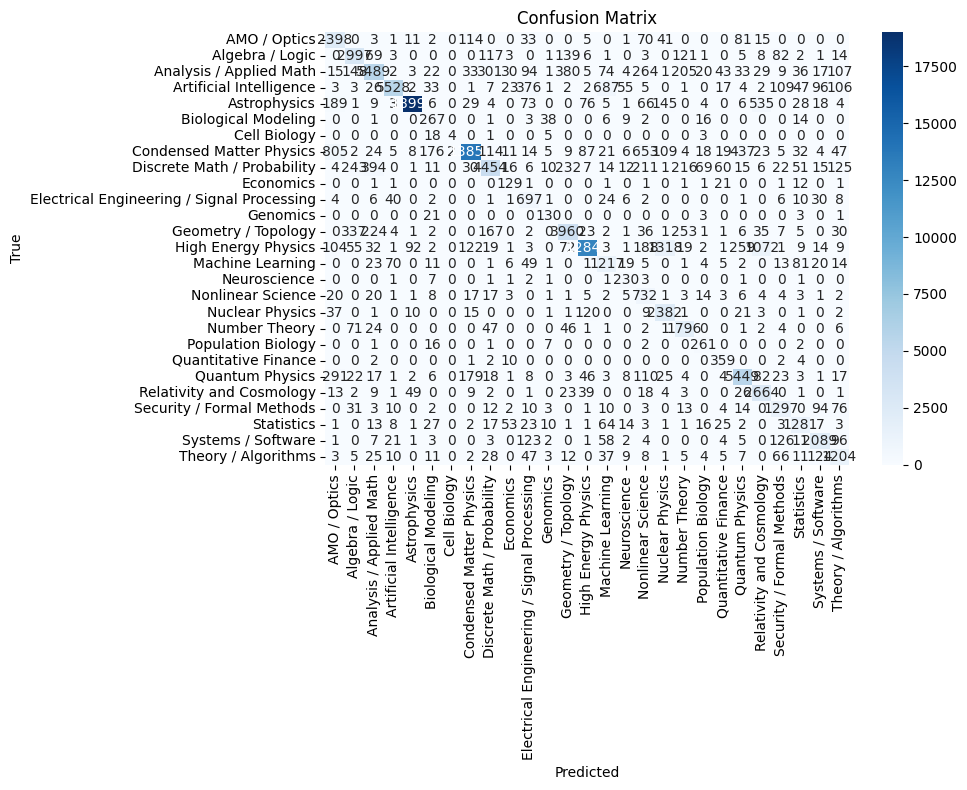

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_and_prepare_test_data(df, model_name="bert-base-uncased", max_predict_samples=-1):
    # Clean and preprocess DataFrame
    df = df.dropna(subset=['abstract', 'categories']).copy()
    df['categories'] = df['categories'].str.strip()
    logger.info(f"Loaded dataset with {len(df)} samples after removing NaNs")

    # Encode categories
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['categories'])
    num_labels = len(label_encoder.classes_)
    logger.info(f"Number of labels: {num_labels}")
    logger.info(f"Label mapping: {dict(zip(label_encoder.classes_, range(num_labels)))}")

    # Split data to get test set (10% of data, consistent with original split)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    _, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    logger.info(f"Test size: {len(test_df)}")

    # Reset indices
    test_df = test_df.reset_index(drop=True)

    # Convert to Hugging Face Dataset
    test_dataset = Dataset.from_pandas(test_df[['abstract', 'label']])

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenization function
    def tokenize_function(examples):
        return tokenizer(
            [str(abstract) for abstract in examples["abstract"]],
            padding="max_length",
            truncation=True,
            max_length=512
        )

    # Tokenize test dataset
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Subset data if max_predict_samples is specified
    if max_predict_samples != -1:
        test_dataset = test_dataset.select(range(min(max_predict_samples, len(test_dataset))))

    # Set format for PyTorch
    test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

    return test_dataset, label_encoder, num_labels

def plot_confusion_matrix(test_dataset, label_encoder, model_path, batch_size=16):
    # Load model (config + weights) directly from directory
    num_labels = len(label_encoder.classes_)
    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels)

    # Define training arguments for prediction
    training_args = TrainingArguments(
        output_dir="./temp",
        per_device_eval_batch_size=batch_size,
    )

    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
    )

    # Make predictions
    predictions = trainer.predict(test_dataset)
    preds = predictions.predictions.argmax(-1)
    true_labels = predictions.label_ids

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    logger.info("Confusion matrix saved as 'confusion_matrix.png'")
    plt.close()

# Example usage:
model_path = "/content/drive/MyDrive/bert_model_results_full"  # must contain config.json + pytorch_model.bin
test_dataset, label_encoder, num_labels = load_and_prepare_test_data(df_filtered)
plot_confusion_matrix(test_dataset, label_encoder, model_path)
